In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1 General Port Parameters

In [2]:
year              = 2018   # current year within simulation
simulation_window = 20     # looking 20 years ahead
start_year        = 2018   # start year of simulation
timestep          = year - start_year
operational_hours = 8760   # operational hours per year

# 2 Scenario Generator

In [3]:
import terminal_optimization.plot_file as plot_file
from terminal_optimization.forecast import maize, soybean, wheat, handysize, handymax, panamax

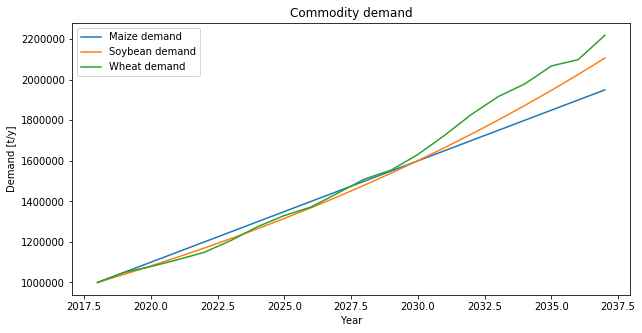

In [4]:
# Generating a single demand forecast

# Maize - Linear demand
demand_maize  = 1000000        # demand at t=0
growth_maize  = 50000       

# Soybean - Exponential demand
demand_soybean = 1000000
rate_soybean   = 1.04          # year on year growth rate of demand (% points) - input for constant method and random method

# Wheat - Probabilistic demand
demand_wheat   = 1000000
rate_wheat     = 1.03
mu_wheat       = 0.01          # avg bonus rate added to base rate (% points)  - input for random method
sigma_wheat    = 0.015         # standard deviation of bonus rate (% points)   - input for random method

maize.linear_forecast        (year, simulation_window, demand_maize, growth_maize)
soybean.exponential_forecast (year, simulation_window, demand_soybean, rate_soybean)
wheat.random_forecast        (year, simulation_window, demand_wheat, rate_wheat, mu_wheat, sigma_wheat)

plot_file.trend(maize, soybean, wheat, 10, 5)

# Port Model

In [5]:
import terminal_optimization.investment_decisions as invest
import terminal_optimization.infrastructure       as infra
import terminal_optimization.business_logic       as financial

In [6]:
asset_objects = [infra.quay_object, infra.berth_object, infra.cranes_object, infra.storage_object, 
                 infra.station_object, infra.quay_conveyor_object, infra.hinterland_conveyor_object]
assets        = 7*[0]
vessels       = [handysize, handymax, panamax]
commodities   = [maize, soybean, wheat]

# Simulator

In [7]:
def simulate(start_year, simulation_window):
    
    for i in range (start_year, start_year + simulation_window):
        year = i 
        timestep = year - start_year
    
        if timestep == 0: 
            quays       = [infra.quay_object]
            berths      = [infra.berth_object]
            cranes      = [[infra.cranes_object[0]], [infra.cranes_object[1]], [infra.cranes_object[2]], [infra.cranes_object[3]]]
            storage     = [[infra.storage_object[0]],[infra.storage_object[1]]] 
            stations    = [infra.station_object]
            q_conveyors = [infra.quay_conveyor_object]
            h_conveyors = [infra.hinterland_conveyor_object]
            throughputs = []
            revenues    = []
            capex       = []
            labour      = []
            maintenance = []
            energy      = []
            insurance   = []
            lease       = []
            demurrage   = []
            residuals   = []
            profits     = []
            opex        = []

        ######################
        # Investment Decisions
        ######################

        # Berths
        allowable_berth_occupancy = 0.40
        berths, cranes = invest.berth_invest_decision(berths, cranes, infra.berth_object, allowable_berth_occupancy, vessels, year, timestep, operational_hours)
        
        # Quay
        quays = invest.quay_invest_decision(quays, berths, infra.quay_object, year, timestep)

        # Cranes 
        cranes = invest.crane_invest_decision(cranes, berths, infra.cranes_object, year, timestep)

        # Storage
        storage_type            = 'Silos'
        trigger_throughput_perc = 10  # Percentage of annual throughput which triggers the investment in a new storage unit
        aspired_throughput_perc = 20  # Aspired of annual throughput which is realised due to the new storage unit
        storage = invest.storage_invest_decision(storage, infra.storage_object, trigger_throughput_perc, aspired_throughput_perc,storage_type, commodities, year, timestep)

        # Loading stations
        station_utilisation     = 0.60 # Loading station utilisation
        trigger_throughput_perc = 80   # Percentage of hourly peak demand which triggers the investment in a new loading unit
        aspired_throughput_perc = 120  # Aspired percentage of hourly peak demand which is realised due to the new loading unit
        stations = invest.station_invest_decision(stations, infra.station_object, station_utilisation, trigger_throughput_perc, aspired_throughput_perc, commodities, year, timestep, operational_hours)

        # Conveyors
        q_conveyors = invest. quay_conveyor_invest_decision(q_conveyors, cranes, infra.quay_conveyor_object, year, timestep, operational_hours)
        h_conveyors = invest. hinterland_conveyor_invest_decision(h_conveyors, stations, infra.hinterland_conveyor_object, year, timestep, operational_hours)

        ######################
        # Business Logic
        ######################

        # Terminal throughput
        throughputs = financial.throughput_calc(throughputs, berths, cranes, year, timestep, operational_hours)

        # Revenues
        revenues = financial.revenue_calc(revenues, commodities, throughputs, year, timestep)

        # Capex
        capex = financial.capex_calc(capex, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Labour costs
        labour = financial.labour_calc(labour, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep, operational_hours)

        # Maintenance costs
        maintenance = financial.maintenance_calc(maintenance, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Energy costs
        energy = financial.energy_calc(energy, berths, cranes, storage, stations, q_conveyors, h_conveyors, year, operational_hours, timestep)

        # Insurance costs
        insurance = financial.insurance_calc(insurance, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Lease costs 
        lease = financial.lease_calc(lease, year,timestep)

        # Demurrage costs
        demurrage = financial.demurrage_calc(demurrage, year, berths, handysize, handymax, panamax, timestep)

        # Residual value calculations 
        residuals = financial.residual_calc(residuals, quays, cranes, storage, stations, q_conveyors, h_conveyors, assets, year, timestep)

        # Profits
        profits = financial.profit_calc(profits, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, simulation_window, timestep, year, start_year)
        
        # Opex
        opex = financial.opex_calc(opex, labour, maintenance, energy, insurance, lease, demurrage, year, timestep)
        
    return quays, berths, cranes, storage, stations, q_conveyors, h_conveyors, throughputs, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, profits, opex

In [8]:
quays, berths, cranes, storage, stations, q_conveyors, h_conveyors, throughputs, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, profits, opex = simulate(start_year, simulation_window)

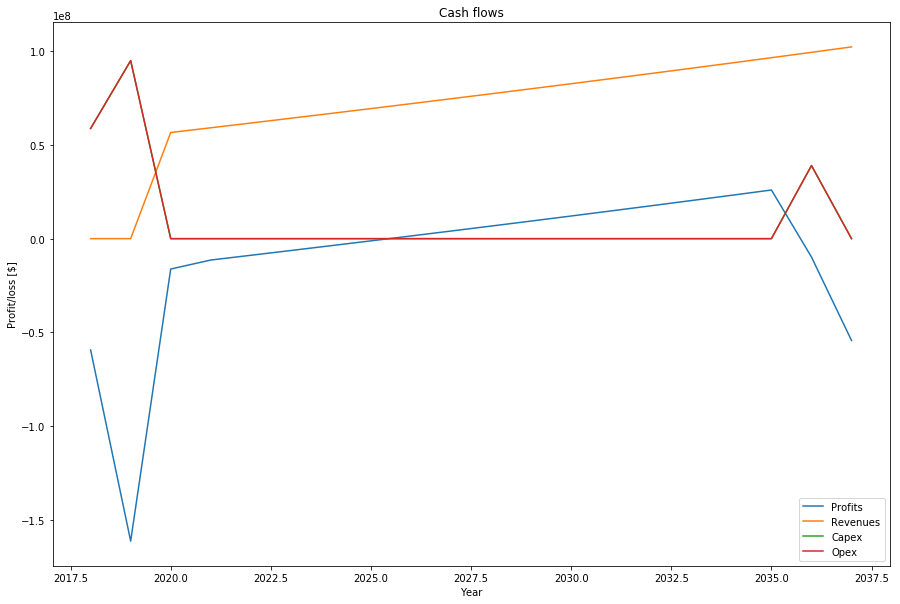

In [9]:
plot_file.cashflows(profits, revenues, capex, opex, 15, 10)

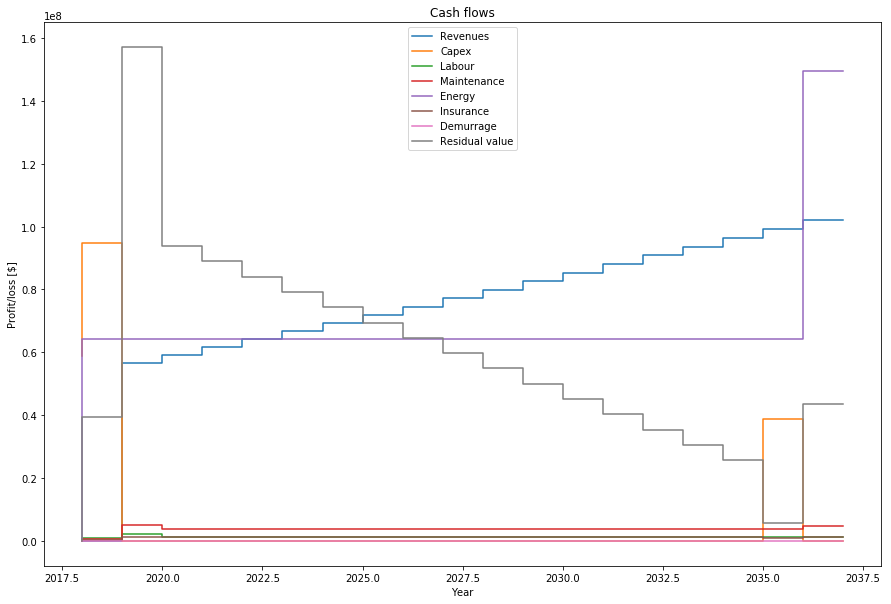

In [10]:
plot_file.all_cashflows(revenues, capex, labour, maintenance, energy, insurance, demurrage, residuals, 15, 10)

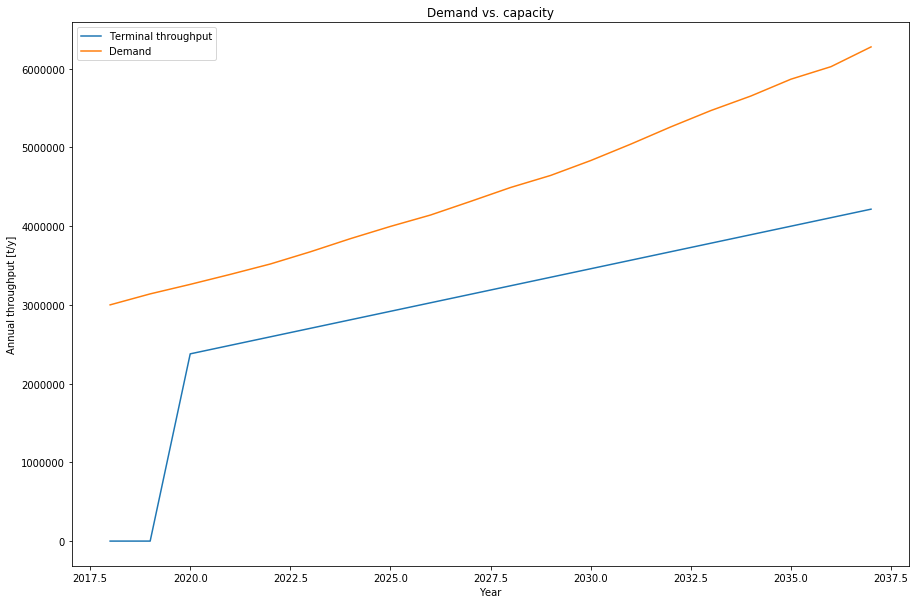

In [11]:
plot_file.throughput(commodities, throughputs, 15, 10)